In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = './dataset2/'

In [3]:
x_train_dir = os.path.join(DATA_DIR, 'train_images')
y_train_dir = os.path.join(DATA_DIR, 'train_annotations')

x_valid_dir = os.path.join(DATA_DIR, 'val_images')
y_valid_dir = os.path.join(DATA_DIR, 'val_annotations')

## Dataloader

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background', 'blob']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return (batch[0],batch[1])
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

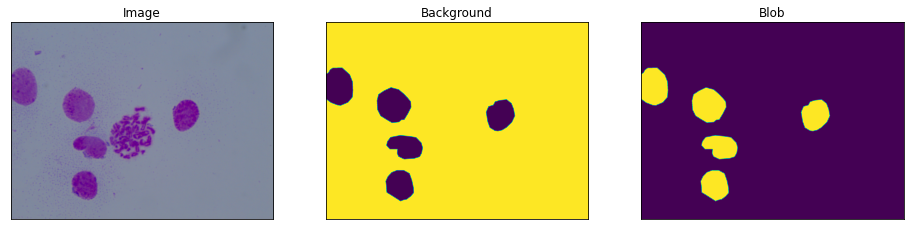

In [5]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['background', 'blob'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    background=mask[..., 0].squeeze(),
    blob=mask[..., 1].squeeze(),
)

## Augmentation

In [6]:
import albumentations as A

In [7]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.Resize (320, 480, interpolation=1, always_apply=True, p=1),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480, always_apply=True)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)


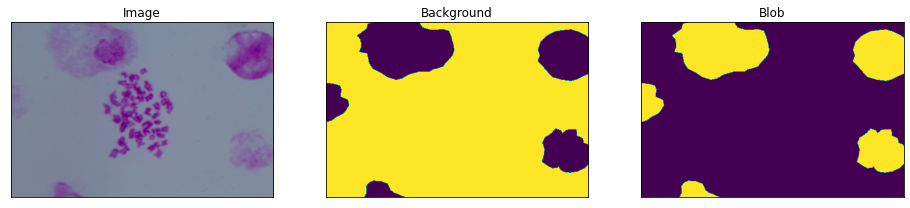

In [8]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['background', 'blob'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    background=mask[..., 0].squeeze(),
    blob=mask[..., 1].squeeze(),
)

## Model

In [9]:
%env SM_FRAMEWORK=tf.keras

import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [10]:
BACKBONE = 'inceptionv3'
BATCH_SIZE = 2
CLASSES = ['background', 'blob']
LR = 0.0001
EPOCHS = 5

preprocess_input = sm.get_preprocessing(BACKBONE)

In [11]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

def build_model_func():
    #create model
    model = sm.FPN(BACKBONE, classes=n_classes, activation=activation)

    # define optomizer
    optim = keras.optimizers.Adam(LR)

    # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)

    # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
    # total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.AUC()]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, total_loss, metrics)
    return model

In [12]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 480, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 480, n_classes)



# define callbacks for learning rate scheduling and best checkpoints saving
filepath = "checkpoints/saved_weights.{epoch:02d}.hdf5"
callbacks = [
    keras.callbacks.ModelCheckpoint(
            filepath, 
            save_weights_only=True, 
            save_best_only=False, 
            mode="min",
            verbose=0,
            save_freq='epoch',
        ),
    keras.callbacks.ReduceLROnPlateau(),
]

In [13]:
print(valid_dataloader[0][0].shape)

(1, 320, 480, 3)


In [14]:
#checkpoint_path = "checkpoints/saved_weights.03.hdf5"
checkpoint_path = None
from tensorflow.keras.models import model_from_json

def get_init_epoch(checkpoint_path):
    return int(checkpoint_path.split('.')[1])

# Load checkpoint:
if checkpoint_path is not None:
    # Load model:
    model = build_model_func()
    model.load_weights(checkpoint_path)
    # Finding the epoch index from which we are resuming
    initial_epoch = get_init_epoch(checkpoint_path)
    # Calculating the correct value of count
    count = initial_epoch*BATCH_SIZE
    # Update the value of count in callback instance
    callbacks[1].count = count
else:
    model = build_model_func()
    initial_epoch = 0

# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=100, 
    callbacks=callbacks,
    initial_epoch=initial_epoch,
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/100
35/35 [==============================] - 23s 657ms/step - loss: 0.5146 - iou_score: 0.5580 - f1-score: 0.6103 - precision: 0.9365 - auc: 0.9748 - val_loss: 0.5160 - val_iou_score: 0.5171 - val_f1-score: 0.5741 - val_precision: 0.9574 - val_auc: 0.9756
Epoch 2/100
35/35 [==============================] - 21s 603ms/step - loss: 0.3799 - iou_score: 0.9031 - f1-score: 0.9255 - precision: 0.9888 - auc: 0.9979 - val_loss: 0.4413 - val_iou_score: 0.8594 - val_f1-score: 0.8944 - val_precision: 0.9838 - val_auc: 0.9938
Epoch 3/100
35/35 [==============================] - 20s 572ms/step - loss: 0.3631 - iou_score: 0.9645 - f1-score: 0.9812 - precision: 0.9921 - auc: 0.9990 - val_loss: 0.4211 - val_iou_score: 0.9354 - val_f1-score: 0.9637 - val_precision: 0.9861 - val_auc: 0.9936
Epoch 4/100
35/35 [==============================] - 20s 561ms/step - loss: 0.3571 - iou_score: 0.9692 - f1-score: 0.9838 - precision: 0.9932 - auc: 0.9991 - val_loss: 0.4074 - val_iou_score: 0.9148 - val_f1-

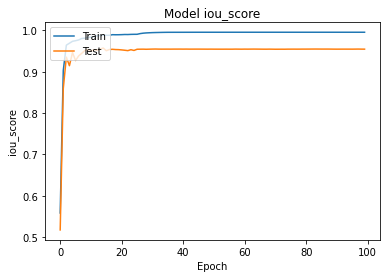

In [15]:
# Plot training & validation iou_score values
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

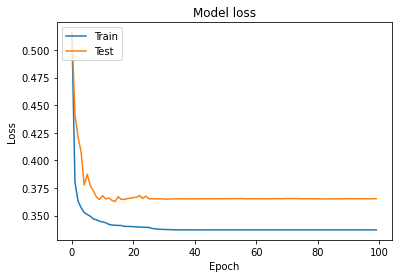

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

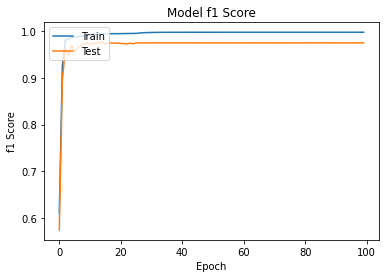

In [17]:
# Plot training & validation loss values
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1 Score')
plt.ylabel('f1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

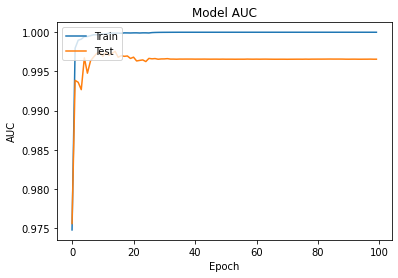

In [18]:
# Plot training & validation loss values
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

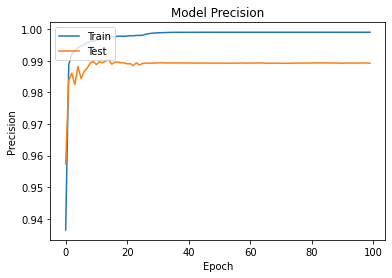

In [19]:
# Plot training & validation loss values
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

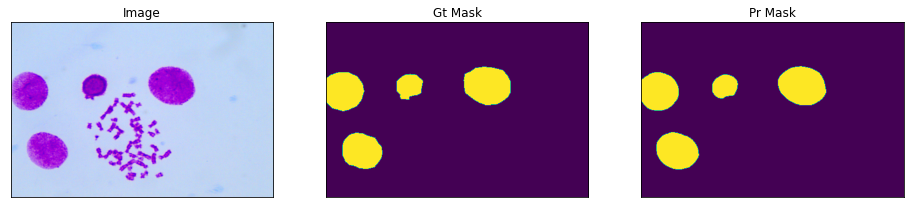

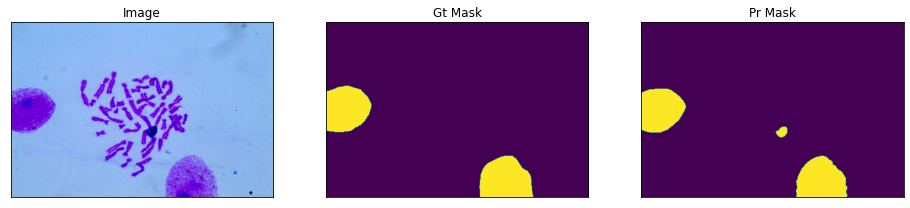

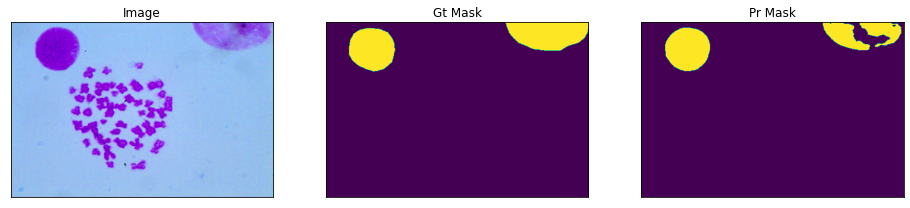

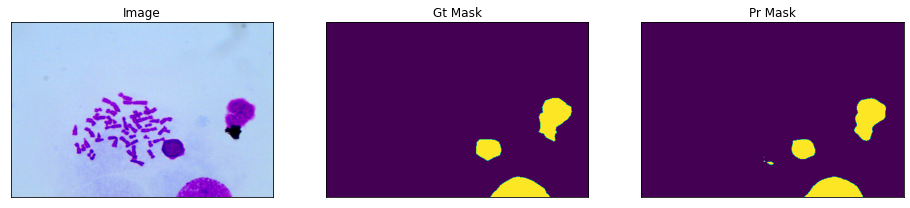

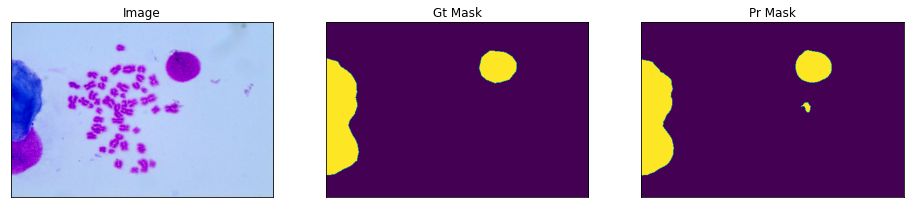

In [20]:
n = 5

for i in range(n):
    
    image, gt_mask = valid_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 1].squeeze(),
        pr_mask=pr_mask[..., 1].squeeze(),
    )